# Imports

In [ ]:
from abc import ABC
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from skimage.io import imread
from skimage.transform import resize
from time import time
from pytorch_toolbelt import losses as L

from torchsummary import summary

from google.colab import drive
import zipfile

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Google drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/datasets/Ph2Dataset.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dataset')

In [ ]:
def plot_images():
    plt.figure(figsize=(18, 6))
    for i in range(6):
        plt.subplot(2, 6, i+1)
        plt.axis("off")
        plt.imshow(X[i])
        plt.subplot(2, 6, i+7)
        plt.axis("off")
        plt.imshow(Y[i])
    plt.show()

images = []
lesions = []
root = '/content/dataset/PH2Dataset/PH2Dataset'
for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root,files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root,files[0])))
size = (256, 256)
X = [resize(x, size, mode='constant',anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant',anti_aliasing=False) > 0.5 for y in lesions]
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')
len(lesions)
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])
print(len(tr), len(val), len(ts))

Loaded 200 images
100 50 50


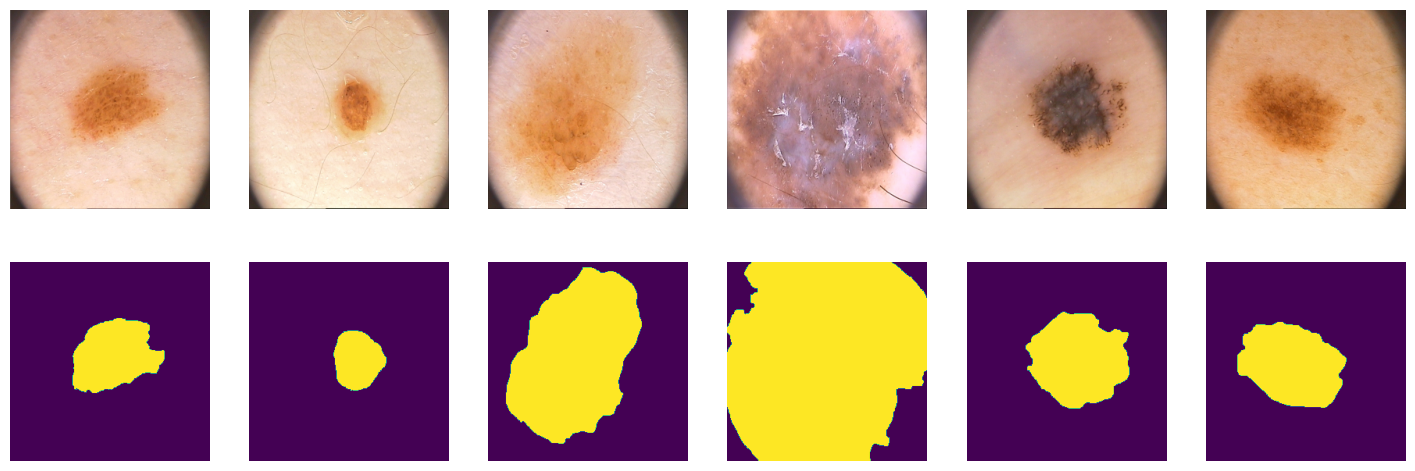

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])
    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show()

# Dataloaders

In [ ]:
batch_size = 12
# noinspection PyTypeChecker
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1),Y[tr, np.newaxis])), batch_size=batch_size,shuffle=True)
# noinspection PyTypeChecker
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3,1), Y[val, np.newaxis])), batch_size=batch_size,shuffle=True)
# noinspection PyTypeChecker
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1),Y[ts, np.newaxis])), batch_size=batch_size,shuffle=True)

## Функции для обучения

In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=3,padding=1),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_channels, out_channels, kernel_size=3,padding=1),
          nn.ReLU(inplace=True))


def crop_image(input_tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = input_tensor.size()[2]
    delta = (tensor_size - target_size) // 2
    return input_tensor[:, :, delta:tensor_size - delta, delta:tensor_size - delta]

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels:torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    smooth = 1e-8
    intersection = (outputs & labels)
    # print(intersection)
    union = (outputs | labels)
    # print(union)
    iou = (intersection + smooth) / (union + smooth)
    # print(iou)
    thresholded = torch.clamp(20 * (iou - 0.5), 0,10).ceil() / 10
    # print(thresholded)
    return thresholded

In [ ]:
def predict(model1, data):
    model1.eval()
    y_pred = [X_batch for X_batch, _ in data]
    return np.array(y_pred)

def score_model(model1, metric, data):
    model1.eval()
    scores = 0
    threshold = 0.5
    for X_batch, Y_label in data:
        y_pred = model(X_batch.to(device))
        y_pred = (y_pred > threshold).float()
        scores += metric(y_pred,Y_label.to(device)).mean().item()
        # print(scores)
    return scores/len(data)

def show_images(x_val, y_val, y_hat, epoch, epochs,avg_loss):
    for k in range(6):
        plt.subplot(3, 6, k + 1)
        plt.imshow(np.rollaxis(x_val[k].numpy(), 0, 3),
        cmap='gray')
        plt.title('Image')
        plt.axis('off')
        plt.subplot(3, 6, k + 7)
        plt.imshow(y_val[k, 0], cmap='gray')
        plt.title('Labels')
        plt.axis('off')
        plt.subplot(3, 6, k + 13)
        # print(y_hat[k, 0])
        # print(y_hat[k, 0].numpy())
        # print(np.round(y_hat[k, 0].numpy()))
        plt.imshow(np.round(y_hat[k, 0].numpy()),cmap='gray')
        plt.title('Predicted')
        plt.axis('off')
    plt.suptitle('%d / %d - loss: %f' % (epoch, epochs,avg_loss))
    plt.show()


In [ ]:
def train(model1, opt, loss_fn, epochs, data_tr,data_val):
    x_val, y_val = next(iter(data_val))
    start_time = time()
    for epoch in range(epochs):
        avg_loss = 0
        avg_loss2 = 0
        model.train() # train mode
        for X_batch, Y_batch in data_tr:
            inputs = X_batch.to(device)
            labels = Y_batch.to(device)
            opt.zero_grad()
            y_pred = model(inputs)
            loss = loss_fn(y_pred, labels)
            loss.backward()
            opt.step()
            avg_loss += loss / len(data_tr)
        model.eval()
        for X_batch2, Y_batch2 in data_val:
            inputs2 = X_batch2.to(device)
            y_pred2 = model(inputs2).cpu().detach()
            loss2 = loss_fn(y_pred2, Y_batch2)
            avg_loss2 += loss2 / len(data_val)
        train_score = score_model(model1, iou_pytorch,data_tr)
        test_score = score_model(model1, iou_pytorch,data_val)
        if (epoch+1) % 1 == 0:
            print('Epoch: %d/%d, train loss: %f, test loss: %f, train score: %f, test score: %f' % (epoch+1,epochs,
                                                                                                    avg_loss, avg_loss2,
                                                                                                    train_score, test_score))
        if epoch+1 == epochs:
            y_hat =model(x_val.to(device)).detach().to('cpu')
            show_images(x_val, y_val, y_hat, epoch+1,epochs, avg_loss)
    print('Elapsed time: %s' % np.round((time() -start_time), 1))

# Unet

In [ ]:
class UNet(nn.Module, ABC):
    def __init__(self):
        super().__init__()
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)
        self.conv_down5 = double_conv(512, 1024)
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.upsample = nn.Upsample(scale_factor=2,mode='bilinear', align_corners=True)
        self.trans_up1 =nn.ConvTranspose2d(in_channels=1024, out_channels=512,kernel_size=2, stride=2)
        self.conv_up1 = double_conv(1024, 512)
        self.trans_up2 =nn.ConvTranspose2d(in_channels=512, out_channels=256,kernel_size=2, stride=2)
        self.conv_up2 = double_conv(512, 256)
        self.trans_up3 =nn.ConvTranspose2d(in_channels=256, out_channels=128,kernel_size=2, stride=2)
        self.conv_up3 = double_conv(256, 128)
        self.trans_up4 =nn.ConvTranspose2d(in_channels=128, out_channels=64,kernel_size=2, stride=2)
        self.conv_up4 = double_conv(128, 64)
        self.last_conv = nn.Conv2d(in_channels=64,out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(self, image):
        # Encoder part
        x1 = self.conv_down1(image)
        x2 = self.maxpool(x1)
        x3 = self.conv_down2(x2)
        x4 = self.maxpool(x3)
        x5 = self.conv_down3(x4)
        x6 = self.maxpool(x5)
        x7 = self.conv_down4(x6)
        x8 = self.maxpool(x7)
        x9 = self.conv_down5(x8)
        # Decoder part
        x = self.trans_up1(x9)
        y = crop_image(x7, x)
        x = self.conv_up1(torch.cat([x, y], 1))
        x = self.trans_up2(x)
        y = crop_image(x5, x)
        x = self.conv_up2(torch.cat([x, y], 1))
        x = self.trans_up3(x)
        y = crop_image(x3, x)
        x = self.conv_up3(torch.cat([x, y], 1))
        x = self.trans_up4(x)
        y = crop_image(x1, x)
        x = self.conv_up4(torch.cat([x, y], 1))
        out = self.last_conv(x)
        return out

## 1 вариант

Epoch: 1/30, train loss: 0.685278, test loss: 0.679474, train score: 0.690928, test score: 0.714451
Epoch: 2/30, train loss: 0.681053, test loss: 0.677079, train score: 0.688726, test score: 0.740050
Epoch: 3/30, train loss: 0.678526, test loss: 0.681714, train score: 0.689154, test score: 0.742087
Epoch: 4/30, train loss: 0.675173, test loss: 0.669829, train score: 0.672944, test score: 0.721378
Epoch: 5/30, train loss: 0.674391, test loss: 0.668860, train score: 0.683015, test score: 0.734628
Epoch: 6/30, train loss: 0.670541, test loss: 0.665244, train score: 0.668700, test score: 0.709497
Epoch: 7/30, train loss: 0.669075, test loss: 0.669690, train score: 0.684283, test score: 0.721925
Epoch: 8/30, train loss: 0.662531, test loss: 0.651976, train score: 0.677395, test score: 0.740232
Epoch: 9/30, train loss: 0.657887, test loss: 0.653319, train score: 0.673004, test score: 0.691485
Epoch: 10/30, train loss: 0.653443, test loss: 0.643614, train score: 0.683945, test score: 0.690418

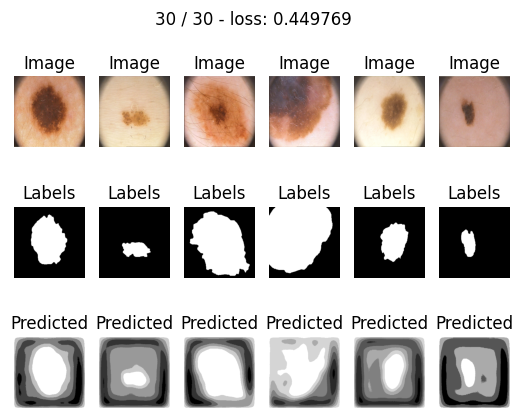

Elapsed time: 249.9


In [ ]:
max_epochs = 30
model = UNet()
loss_function = nn.BCEWithLogitsLoss()
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.00001)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)

## 2 вариант

Epoch: 1/30, train loss: 0.688852, test loss: 0.678439, train score: 0.681773, test score: 0.679804
Epoch: 2/30, train loss: 0.669537, test loss: 0.630906, train score: 0.668250, test score: 0.699308
Epoch: 3/30, train loss: 0.611525, test loss: 0.564700, train score: 0.690218, test score: 0.647325
Epoch: 4/30, train loss: 0.586151, test loss: 0.530647, train score: 0.667424, test score: 0.722964
Epoch: 5/30, train loss: 0.565033, test loss: 0.588763, train score: 0.668988, test score: 0.688905
Epoch: 6/30, train loss: 0.556620, test loss: 0.499879, train score: 0.676607, test score: 0.678586
Epoch: 7/30, train loss: 0.536986, test loss: 0.538195, train score: 0.672987, test score: 0.714879
Epoch: 8/30, train loss: 0.504411, test loss: 0.433866, train score: 0.692678, test score: 0.734366
Epoch: 9/30, train loss: 0.461886, test loss: 0.400378, train score: 0.663947, test score: 0.722052
Epoch: 10/30, train loss: 0.448891, test loss: 0.425142, train score: 0.683614, test score: 0.641177

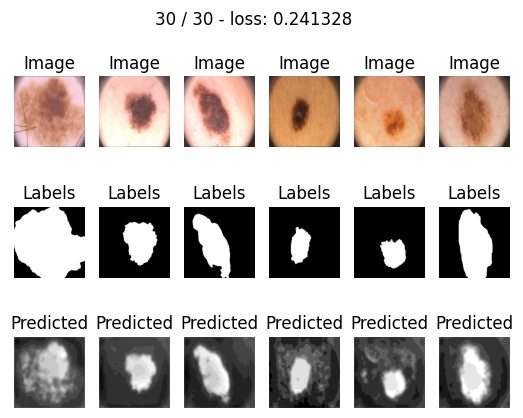

Elapsed time: 252.3
0.9215166926383972


In [ ]:
max_epochs = 30
model = UNet()
loss_function = nn.BCEWithLogitsLoss()
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.0001)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)

## 3 вариант

Epoch: 1/50, train loss: 0.681451, test loss: 0.664946, train score: 0.679403, test score: 0.738734
Epoch: 2/50, train loss: 0.653477, test loss: 0.633342, train score: 0.678896, test score: 0.708804
Epoch: 3/50, train loss: 0.602309, test loss: 0.561636, train score: 0.674899, test score: 0.715140
Epoch: 4/50, train loss: 0.605423, test loss: 0.559318, train score: 0.692405, test score: 0.685413
Epoch: 5/50, train loss: 0.549755, test loss: 0.511307, train score: 0.690583, test score: 0.707424
Epoch: 6/50, train loss: 0.529520, test loss: 0.556373, train score: 0.675592, test score: 0.699864
Epoch: 7/50, train loss: 0.538837, test loss: 0.495828, train score: 0.686546, test score: 0.727015
Epoch: 8/50, train loss: 0.516486, test loss: 0.484471, train score: 0.681995, test score: 0.725792
Epoch: 9/50, train loss: 0.484950, test loss: 0.408830, train score: 0.669216, test score: 0.651214
Epoch: 10/50, train loss: 0.466551, test loss: 0.421473, train score: 0.673267, test score: 0.743557

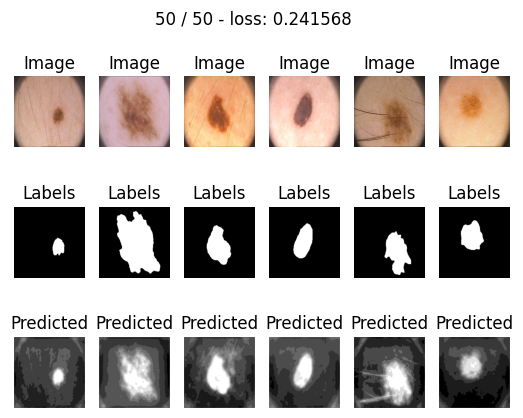

Elapsed time: 414.4
0.9136571407318115


In [ ]:
max_epochs = 50
model = UNet()
loss_function = nn.BCEWithLogitsLoss()
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.0001)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)

## 4 вариант

Epoch: 1/75, train loss: 0.688153, test loss: 0.680153, train score: 0.685264, test score: 0.729428
Epoch: 2/75, train loss: 0.668995, test loss: 0.646090, train score: 0.674493, test score: 0.693608
Epoch: 3/75, train loss: 0.614383, test loss: 0.530908, train score: 0.662131, test score: 0.726345
Epoch: 4/75, train loss: 0.593224, test loss: 0.538504, train score: 0.670917, test score: 0.669580
Epoch: 5/75, train loss: 0.567339, test loss: 0.552486, train score: 0.685270, test score: 0.694329
Epoch: 6/75, train loss: 0.554021, test loss: 0.575533, train score: 0.686906, test score: 0.729891
Epoch: 7/75, train loss: 0.541924, test loss: 0.510146, train score: 0.683234, test score: 0.725293
Epoch: 8/75, train loss: 0.501489, test loss: 0.454769, train score: 0.673402, test score: 0.708777
Epoch: 9/75, train loss: 0.450245, test loss: 0.448269, train score: 0.665241, test score: 0.694093
Epoch: 10/75, train loss: 0.448528, test loss: 0.420078, train score: 0.664253, test score: 0.682242

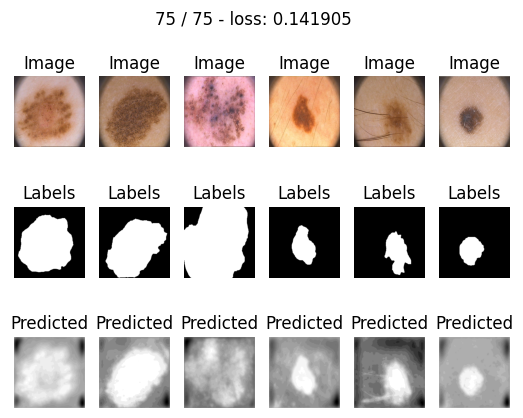

Elapsed time: 622.1
0.9314010739326477


In [ ]:
max_epochs = 75
model = UNet()
loss_function = nn.BCEWithLogitsLoss()
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.0001)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)

## 5 вариант CrossEntropyLoss

In [ ]:
max_epochs = 50
model = UNet()
loss_function = nn.CrossEntropyLoss()
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.0001)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)

Epoch: 1/50, train loss: 0.000000, test loss: 0.000000, train score: 0.675239, test score: 0.737185
Epoch: 2/50, train loss: 0.000000, test loss: 0.000000, train score: 0.678402, test score: 0.695141
Epoch: 3/50, train loss: 0.000000, test loss: 0.000000, train score: 0.680531, test score: 0.741384


KeyboardInterrupt: 

## 6 вариант DiceLoss 0.00001

In [ ]:
class BinaryDiceLoss(nn.Module):

    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))


class DiceLoss(nn.Module):

    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.kwargs = kwargs
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        assert predict.shape == target.shape, 'predict & target shape do not match'
        dice = BinaryDiceLoss(**self.kwargs)
        total_loss = 0
        predict = F.softmax(predict, dim=1)

        for i in range(target.shape[1]):
            if i != self.ignore_index:
                dice_loss = dice(predict[:, i], target[:, i])
                if self.weight is not None:
                    assert self.weight.shape[0] == target.shape[1], \
                        'Expect weight shape [{}], get[{}]'.format(target.shape[1], self.weight.shape[0])
                    dice_loss *= self.weights[i]
                total_loss += dice_loss

        return total_loss/target.shape[1]

Epoch: 1/5, train loss: 0.803124, test loss: 0.649036, train score: 0.662845, test score: 0.683056
Epoch: 2/5, train loss: 0.641760, test loss: 0.604285, train score: 0.678863, test score: 0.628481
Epoch: 3/5, train loss: 0.550822, test loss: 0.607350, train score: 0.669490, test score: 0.658692
Epoch: 4/5, train loss: 0.514842, test loss: 0.429627, train score: 0.668212, test score: 0.670927
Epoch: 5/5, train loss: 0.410149, test loss: 0.433378, train score: 0.831878, test score: 0.818669
tensor([[0.0528, 0.1629, 0.2746,  ..., 0.4582, 0.3806, 0.2509],
        [0.0605, 0.2460, 0.4446,  ..., 0.7572, 0.6246, 0.4015],
        [0.0844, 0.3161, 0.5684,  ..., 0.9345, 0.7728, 0.4929],
        ...,
        [0.1765, 0.4496, 0.6913,  ..., 0.8797, 0.7228, 0.4552],
        [0.1318, 0.3458, 0.5394,  ..., 0.6709, 0.5477, 0.3446],
        [0.0671, 0.1825, 0.2871,  ..., 0.3512, 0.2870, 0.1792]])
[[0.05281118 0.16287974 0.27462685 ... 0.45820627 0.38055947 0.25088704]
 [0.06054148 0.2460399  0.44460678

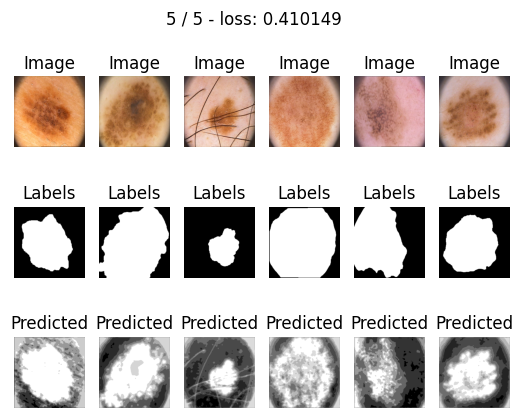

Elapsed time: 41.6
0.8704063534736634


In [ ]:
max_epochs = 5
model = UNet()
loss_function = nn.BCEWithLogitsLoss()
# loss_function = DiceLoss()
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)

Epoch: 1/10, train loss: 0.770324, test loss: 0.761641, train score: 0.664391, test score: 0.711714
Epoch: 2/10, train loss: 0.766718, test loss: 0.770006, train score: 0.677537, test score: 0.658291
Epoch: 3/10, train loss: 0.774221, test loss: 0.737988, train score: 0.663403, test score: 0.709079
Epoch: 4/10, train loss: 0.769589, test loss: 0.784068, train score: 0.665562, test score: 0.637567
Epoch: 5/10, train loss: 0.770785, test loss: 0.772236, train score: 0.669615, test score: 0.684200
Epoch: 6/10, train loss: 0.778845, test loss: 0.787619, train score: 0.659506, test score: 0.651019
Epoch: 7/10, train loss: 0.768497, test loss: 0.762978, train score: 0.656833, test score: 0.656206
Epoch: 8/10, train loss: 0.762021, test loss: 0.793724, train score: 0.661781, test score: 0.618657
Epoch: 9/10, train loss: 0.768869, test loss: 0.765765, train score: 0.678025, test score: 0.679040
Epoch: 10/10, train loss: 0.778161, test loss: 0.791915, train score: 0.664141, test score: 0.676425

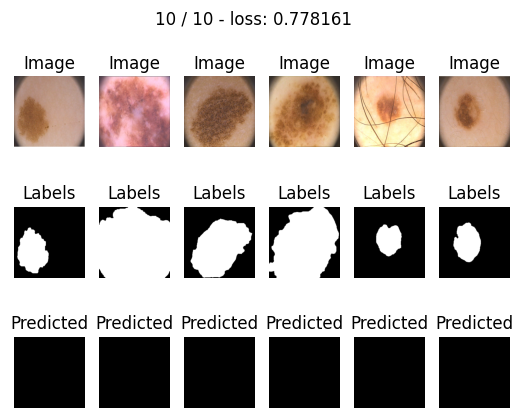

Elapsed time: 82.9
0.7113800168037414


In [ ]:
max_epochs = 10
model = UNet()
# loss_function = nn.BCEWithLogitsLoss()
loss_function = DiceLoss()
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)

Epoch: 1/50, train loss: 0.606542, test loss: 0.604668, train score: 0.664405, test score: 0.675737
Epoch: 2/50, train loss: 0.595336, test loss: 0.626352, train score: 0.666623, test score: 0.654623
Epoch: 3/50, train loss: 0.616732, test loss: 0.608010, train score: 0.674828, test score: 0.702295
Epoch: 4/50, train loss: 0.608176, test loss: 0.589335, train score: 0.663744, test score: 0.631791
Epoch: 5/50, train loss: 0.603848, test loss: 0.592538, train score: 0.677817, test score: 0.673401
Epoch: 6/50, train loss: 0.609311, test loss: 0.605290, train score: 0.655512, test score: 0.617835
Epoch: 7/50, train loss: 0.599076, test loss: 0.587191, train score: 0.670055, test score: 0.651138
Epoch: 8/50, train loss: 0.599170, test loss: 0.602217, train score: 0.652095, test score: 0.604503
Epoch: 9/50, train loss: 0.605790, test loss: 0.617571, train score: 0.672722, test score: 0.683480
Epoch: 10/50, train loss: 0.611980, test loss: 0.571851, train score: 0.671548, test score: 0.700908

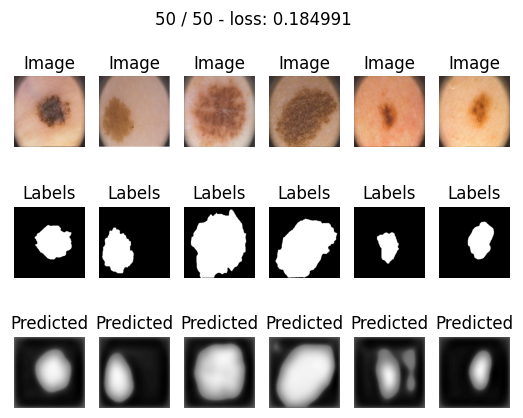

Elapsed time: 422.4
0.9149915337562561


In [ ]:
max_epochs = 50
model = UNet()
# loss_function = nn.BCEWithLogitsLoss()
loss_function = L.DiceLoss('binary')
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.00001)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)

## 7 вариант DiceLoss 0.0001

In [ ]:
max_epochs = 50
model = UNet()
loss_function = L.DiceLoss('binary')
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.0001)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)

Epoch: 1/50, train loss: 0.613755, test loss: 0.593775, train score: 0.669926, test score: 0.635747
Epoch: 2/50, train loss: 0.604281, test loss: 0.616715, train score: 0.681526, test score: 0.694883
Epoch: 3/50, train loss: 0.589065, test loss: 0.561176, train score: 0.651451, test score: 0.679051
Epoch: 4/50, train loss: 0.523772, test loss: 0.531199, train score: 0.325875, test score: 0.292413
Epoch: 5/50, train loss: 0.499100, test loss: 0.547362, train score: 0.326990, test score: 0.336346
Epoch: 6/50, train loss: 0.506233, test loss: 0.531282, train score: 0.335063, test score: 0.323289
Epoch: 7/50, train loss: 0.513131, test loss: 0.522592, train score: 0.332027, test score: 0.303988
Epoch: 8/50, train loss: 0.508425, test loss: 0.481868, train score: 0.334099, test score: 0.298575
Epoch: 9/50, train loss: 0.505167, test loss: 0.445050, train score: 0.318923, test score: 0.321690
Epoch: 10/50, train loss: 0.501579, test loss: 0.500041, train score: 0.335349, test score: 0.318515

KeyboardInterrupt: 

## 8 вариант SoftBCEWithLogitsLoss 0.00001

Epoch: 1/50, train loss: 0.696859, test loss: 0.695749, train score: 0.676241, test score: 0.695683
Epoch: 2/50, train loss: 0.694457, test loss: 0.693469, train score: 0.684308, test score: 0.649067
Epoch: 3/50, train loss: 0.692770, test loss: 0.692334, train score: 0.675357, test score: 0.670341
Epoch: 4/50, train loss: 0.691374, test loss: 0.691296, train score: 0.672011, test score: 0.698261
Epoch: 5/50, train loss: 0.689940, test loss: 0.689712, train score: 0.672345, test score: 0.677374
Epoch: 6/50, train loss: 0.688334, test loss: 0.687235, train score: 0.657244, test score: 0.667687
Epoch: 7/50, train loss: 0.686256, test loss: 0.686224, train score: 0.665618, test score: 0.709302
Epoch: 8/50, train loss: 0.683172, test loss: 0.685144, train score: 0.658835, test score: 0.661753
Epoch: 9/50, train loss: 0.681885, test loss: 0.679409, train score: 0.667250, test score: 0.697302
Epoch: 10/50, train loss: 0.676794, test loss: 0.680206, train score: 0.677733, test score: 0.631482

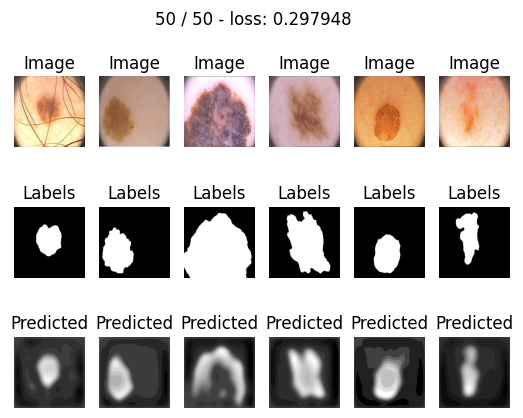

Elapsed time: 418.2
0.9271291255950928


In [ ]:
max_epochs = 50
model = UNet()
loss_function = L.SoftBCEWithLogitsLoss()
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.00001)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)

## 9 вариант SoftBCEWithLogitsLoss 0.0001

Epoch: 1/50, train loss: 0.690502, test loss: 0.683245, train score: 0.673382, test score: 0.694584
Epoch: 2/50, train loss: 0.670083, test loss: 0.656109, train score: 0.673049, test score: 0.679565
Epoch: 3/50, train loss: 0.625018, test loss: 0.564134, train score: 0.675761, test score: 0.695469
Epoch: 4/50, train loss: 0.567749, test loss: 0.545423, train score: 0.672614, test score: 0.702009
Epoch: 5/50, train loss: 0.567542, test loss: 0.494400, train score: 0.662186, test score: 0.678408
Epoch: 6/50, train loss: 0.528979, test loss: 0.480900, train score: 0.664564, test score: 0.678635
Epoch: 7/50, train loss: 0.491691, test loss: 0.499065, train score: 0.667640, test score: 0.639962
Epoch: 8/50, train loss: 0.460441, test loss: 0.589894, train score: 0.662507, test score: 0.649080
Epoch: 9/50, train loss: 0.441300, test loss: 0.482684, train score: 0.682848, test score: 0.680259
Epoch: 10/50, train loss: 0.451271, test loss: 0.462837, train score: 0.811867, test score: 0.831451

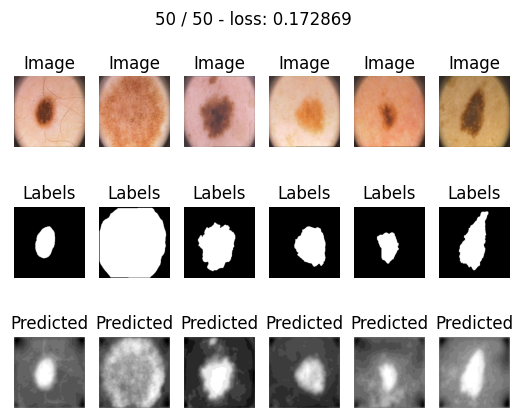

Elapsed time: 417.8
0.9335889458656311


In [ ]:
max_epochs = 50
model = UNet()
loss_function = L.SoftBCEWithLogitsLoss()
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.0001)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)

## Test FocalLoss

In [ ]:
max_epochs = 50
model = UNet()
loss_function = L.FocalLoss('binary')
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.0001)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)

<ipython-input-28-b9447ac242aa>:3: DeprecationWarning: Call to deprecated function FocalLoss (Class FocalLoss is deprecated. Please use CrossEntropyFocalLoss instead.).
  loss_function = L.FocalLoss('binary')


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [12, 1, 256, 256]

# SegNet

In [ ]:
class SegNet(nn.Module):

    def __init__(self, in_chn=3, out_chn=1, BN_momentum=0.5):
        super(SegNet, self).__init__()

        self.in_chn = in_chn
        self.out_chn = out_chn

        self.MaxEn = nn.MaxPool2d(2, stride=2, return_indices=True)

        self.ConvEn11 = nn.Conv2d(self.in_chn, 64, kernel_size=3, padding=1)
        self.BNEn11 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvEn12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNEn12 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvEn21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.BNEn21 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn22 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvEn31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.BNEn31 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn33 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvEn41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.BNEn41 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn43 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvEn51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn51 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn53 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.MaxDe = nn.MaxUnpool2d(2, stride=2)

        self.ConvDe53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe53 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe51 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvDe43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe43 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe41 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.BNDe41 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvDe33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe33 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.BNDe31 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvDe22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe22 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.BNDe21 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvDe12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNDe12 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvDe11 = nn.Conv2d(64, self.out_chn, kernel_size=3, padding=1)
        self.BNDe11 = nn.BatchNorm2d(self.out_chn, momentum=BN_momentum)

    def forward(self, x):

        #ENCODE LAYERS
        #Stage 1
        x = F.relu(self.BNEn11(self.ConvEn11(x)))
        x = F.relu(self.BNEn12(self.ConvEn12(x)))
        x, ind1 = self.MaxEn(x)
        size1 = x.size()

        #Stage 2
        x = F.relu(self.BNEn21(self.ConvEn21(x)))
        x = F.relu(self.BNEn22(self.ConvEn22(x)))
        x, ind2 = self.MaxEn(x)
        size2 = x.size()

        #Stage 3
        x = F.relu(self.BNEn31(self.ConvEn31(x)))
        x = F.relu(self.BNEn32(self.ConvEn32(x)))
        x = F.relu(self.BNEn33(self.ConvEn33(x)))
        x, ind3 = self.MaxEn(x)
        size3 = x.size()

        #Stage 4
        x = F.relu(self.BNEn41(self.ConvEn41(x)))
        x = F.relu(self.BNEn42(self.ConvEn42(x)))
        x = F.relu(self.BNEn43(self.ConvEn43(x)))
        x, ind4 = self.MaxEn(x)
        size4 = x.size()

        #Stage 5
        x = F.relu(self.BNEn51(self.ConvEn51(x)))
        x = F.relu(self.BNEn52(self.ConvEn52(x)))
        x = F.relu(self.BNEn53(self.ConvEn53(x)))
        x, ind5 = self.MaxEn(x)
        size5 = x.size()

        #DECODE LAYERS
        #Stage 5
        x = self.MaxDe(x, ind5, output_size=size4)
        x = F.relu(self.BNDe53(self.ConvDe53(x)))
        x = F.relu(self.BNDe52(self.ConvDe52(x)))
        x = F.relu(self.BNDe51(self.ConvDe51(x)))

        #Stage 4
        x = self.MaxDe(x, ind4, output_size=size3)
        x = F.relu(self.BNDe43(self.ConvDe43(x)))
        x = F.relu(self.BNDe42(self.ConvDe42(x)))
        x = F.relu(self.BNDe41(self.ConvDe41(x)))

        #Stage 3
        x = self.MaxDe(x, ind3, output_size=size2)
        x = F.relu(self.BNDe33(self.ConvDe33(x)))
        x = F.relu(self.BNDe32(self.ConvDe32(x)))
        x = F.relu(self.BNDe31(self.ConvDe31(x)))

        #Stage 2
        x = self.MaxDe(x, ind2, output_size=size1)
        x = F.relu(self.BNDe22(self.ConvDe22(x)))
        x = F.relu(self.BNDe21(self.ConvDe21(x)))

        #Stage 1
        x = self.MaxDe(x, ind1)
        x = F.relu(self.BNDe12(self.ConvDe12(x)))
        x = self.ConvDe11(x)

        x = F.softmax(x, dim=1)

        return x

In [ ]:
model = SegNet()
model.__init__()
model.to(device)
summary(model,(3,512,512),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [12, 64, 512, 512]           1,792
       BatchNorm2d-2         [12, 64, 512, 512]             128
            Conv2d-3         [12, 64, 512, 512]          36,928
       BatchNorm2d-4         [12, 64, 512, 512]             128
         MaxPool2d-5  [[-1, 64, 256, 256], [-1, 64, 256, 256]]               0
            Conv2d-6        [12, 128, 256, 256]          73,856
       BatchNorm2d-7        [12, 128, 256, 256]             256
            Conv2d-8        [12, 128, 256, 256]         147,584
       BatchNorm2d-9        [12, 128, 256, 256]             256
        MaxPool2d-10  [[-1, 128, 128, 128], [-1, 128, 128, 128]]               0
           Conv2d-11        [12, 256, 128, 128]         295,168
      BatchNorm2d-12        [12, 256, 128, 128]             512
           Conv2d-13        [12, 256, 128, 128]         590,080
      B

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels:torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    smooth = 1e-8
    intersection = (outputs & labels)
    union = (outputs | labels)
    iou = (intersection + smooth) / (union + smooth)
    thresholded = torch.clamp(20 * (iou - 0.5), 0,10).ceil() / 10
    return thresholded

In [ ]:
def predict(model1, data):
    model1.eval()
    y_pred = [X_batch for X_batch, _ in data]
    return np.array(y_pred)

def score_model(model1, metric, data):
    model1.eval()
    scores = 0
    threshold = 0.5
    for X_batch, Y_label in data:
        y_pred = model(X_batch.to(device))
        y_pred = (y_pred > threshold).float()
        scores += metric(y_pred,Y_label.to(device)).mean().item()
    return scores/len(data)

def show_images(x_val, y_val, y_hat, epoch, epochs,avg_loss):
    for k in range(6):
        plt.subplot(3, 6, k + 1)
        plt.imshow(np.rollaxis(x_val[k].numpy(), 0, 3),
        cmap='gray')
        plt.title('Image')
        plt.axis('off')
        plt.subplot(3, 6, k + 7)
        plt.imshow(y_val[k, 0], cmap='gray')
        plt.title('Labels')
        plt.axis('off')
        plt.subplot(3, 6, k + 13)
        plt.imshow(np.round(y_hat[k, 0].numpy()),
        cmap='gray')
        plt.title('Predicted')
        plt.axis('off')
    plt.suptitle('%d / %d - loss: %f' % (epoch, epochs,avg_loss))
    plt.show()


In [ ]:
def train(model1, opt, loss_fn, epochs, data_tr,data_val):
    x_val, y_val = next(iter(data_val))
    start_time = time()
    for epoch in range(epochs):
        avg_loss = 0
        avg_loss2 = 0
        model.train() # train mode
        for X_batch, Y_batch in data_tr:
            inputs = X_batch.to(device)
            labels = Y_batch.to(device)
            opt.zero_grad()
            y_pred = model(inputs)
            loss = loss_fn(y_pred, labels)
            loss.backward()
            opt.step()
            avg_loss += loss / len(data_tr)
        model.eval()
        for X_batch2, Y_batch2 in data_val:
            inputs2 = X_batch2.to(device)
            y_pred2 = model(inputs2).cpu().detach()
            loss2 = loss_fn(y_pred2, Y_batch2)
            avg_loss2 += loss2 / len(data_val)
        train_score = score_model(model1, iou_pytorch,data_tr)
        test_score = score_model(model1, iou_pytorch,data_val)
        if (epoch+1) % 1 == 0:
            print('Epoch: %d/%d, train loss: %f, test loss: %f, train score: %f, test score: %f' % (epoch+1,epochs, avg_loss, avg_loss2, train_score, test_score))
        if epoch+1 == epochs:
            y_hat =model(x_val.to(device)).detach().to('cpu')
            show_images(x_val, y_val, y_hat, epoch+1,epochs, avg_loss)
    print('Elapsed time: %s' % np.round((time() -start_time), 1))

## 1 вариант 0.00001

Epoch: 1/15, train loss: 0.985215, test loss: 1.001937, train score: 0.322777, test score: 0.343610
Epoch: 2/15, train loss: 0.971247, test loss: 0.949730, train score: 0.338113, test score: 0.363714
Epoch: 3/15, train loss: 0.987486, test loss: 0.986935, train score: 0.340046, test score: 0.320747
Epoch: 4/15, train loss: 0.979563, test loss: 1.012623, train score: 0.335306, test score: 0.349404
Epoch: 5/15, train loss: 0.990289, test loss: 0.906312, train score: 0.336115, test score: 0.316923
Epoch: 6/15, train loss: 0.992646, test loss: 1.028400, train score: 0.340067, test score: 0.294675
Epoch: 7/15, train loss: 0.978562, test loss: 0.906365, train score: 0.335702, test score: 0.316528
Epoch: 8/15, train loss: 0.966486, test loss: 1.013833, train score: 0.321185, test score: 0.296660
Epoch: 9/15, train loss: 0.979077, test loss: 1.010144, train score: 0.333753, test score: 0.316944
Epoch: 10/15, train loss: 0.977453, test loss: 0.966363, train score: 0.324853, test score: 0.297568

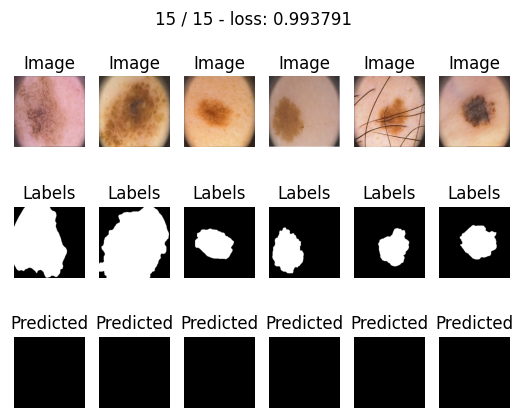

Elapsed time: 105.4
0.2745259702205658


In [ ]:
max_epochs = 15
model = SegNet()
loss_function = nn.BCEWithLogitsLoss()
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.00001)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)

## 2 вариант 0.0001

Epoch: 1/15, train loss: 0.970581, test loss: 1.010939, train score: 0.346300, test score: 0.305109
Epoch: 2/15, train loss: 0.977034, test loss: 1.012784, train score: 0.346645, test score: 0.314009
Epoch: 3/15, train loss: 0.983849, test loss: 0.964572, train score: 0.331637, test score: 0.298526
Epoch: 4/15, train loss: 0.982319, test loss: 1.015024, train score: 0.329636, test score: 0.325510
Epoch: 5/15, train loss: 0.998577, test loss: 0.983697, train score: 0.340562, test score: 0.305870
Epoch: 6/15, train loss: 0.978143, test loss: 1.006804, train score: 0.341959, test score: 0.323575
Epoch: 7/15, train loss: 0.967526, test loss: 1.019720, train score: 0.343534, test score: 0.324527
Epoch: 8/15, train loss: 0.989902, test loss: 0.951944, train score: 0.333726, test score: 0.320246
Epoch: 9/15, train loss: 0.988826, test loss: 0.957449, train score: 0.318965, test score: 0.298133
Epoch: 10/15, train loss: 0.978743, test loss: 1.024837, train score: 0.340774, test score: 0.308417

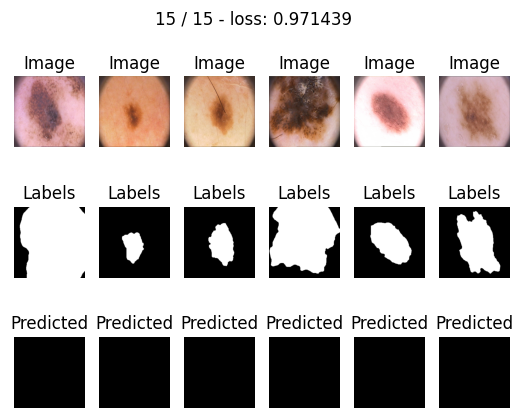

Elapsed time: 105.2
0.34631475508213044


In [ ]:
max_epochs = 15
model = SegNet()
loss_function = nn.BCEWithLogitsLoss()
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.0001)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)

## 3 вариант 0.001

Epoch: 1/15, train loss: 0.976049, test loss: 1.004016, train score: 0.330751, test score: 0.374317
Epoch: 2/15, train loss: 0.978743, test loss: 0.998625, train score: 0.332477, test score: 0.309351
Epoch: 3/15, train loss: 0.973786, test loss: 0.973145, train score: 0.339049, test score: 0.318709
Epoch: 4/15, train loss: 0.993124, test loss: 1.009274, train score: 0.327982, test score: 0.293612
Epoch: 5/15, train loss: 0.994362, test loss: 0.953246, train score: 0.326026, test score: 0.336808
Epoch: 6/15, train loss: 0.993141, test loss: 0.997145, train score: 0.321298, test score: 0.351079
Epoch: 7/15, train loss: 0.981351, test loss: 1.008159, train score: 0.338260, test score: 0.315502
Epoch: 8/15, train loss: 0.992997, test loss: 0.993636, train score: 0.333186, test score: 0.330872
Epoch: 9/15, train loss: 0.967538, test loss: 0.953236, train score: 0.336041, test score: 0.303462
Epoch: 10/15, train loss: 0.983719, test loss: 1.011985, train score: 0.331880, test score: 0.364715

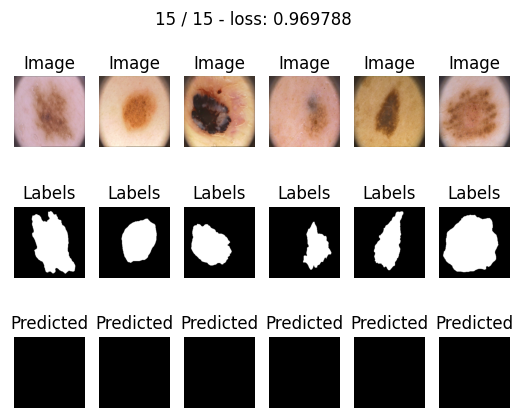

Elapsed time: 105.2
0.2618967771530151


In [ ]:
max_epochs = 15
model = SegNet()
loss_function = nn.BCEWithLogitsLoss()
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)

## 4 варинат 0.01

Epoch: 1/15, train loss: 0.972072, test loss: 1.009274, train score: 0.333272, test score: 0.359731
Epoch: 2/15, train loss: 0.985027, test loss: 0.930751, train score: 0.332071, test score: 0.348981
Epoch: 3/15, train loss: 0.986729, test loss: 0.985673, train score: 0.330132, test score: 0.304832
Epoch: 4/15, train loss: 0.993505, test loss: 1.013587, train score: 0.345775, test score: 0.332637
Epoch: 5/15, train loss: 0.993436, test loss: 1.004146, train score: 0.355565, test score: 0.302543
Epoch: 6/15, train loss: 0.978940, test loss: 1.004306, train score: 0.346327, test score: 0.297097
Epoch: 7/15, train loss: 0.963744, test loss: 0.964519, train score: 0.345673, test score: 0.297977
Epoch: 8/15, train loss: 0.970384, test loss: 0.989973, train score: 0.338463, test score: 0.315607
Epoch: 9/15, train loss: 0.988642, test loss: 1.008888, train score: 0.340667, test score: 0.360131
Epoch: 10/15, train loss: 0.993990, test loss: 0.962183, train score: 0.334774, test score: 0.331144

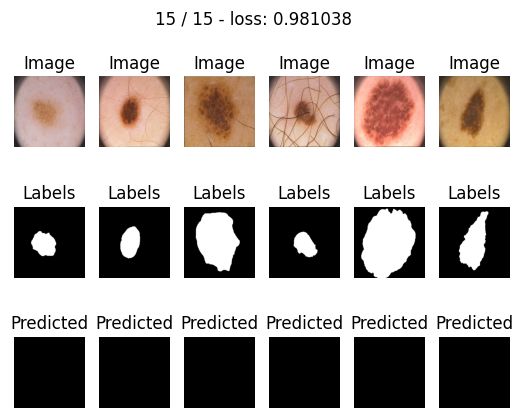

Elapsed time: 104.8
0.32574209570884705


In [ ]:
max_epochs = 15
model = SegNet()
loss_function = nn.BCEWithLogitsLoss()
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.01)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)

## 5 варинат DiceLoss 0.00001

Epoch: 1/50, train loss: 0.615342, test loss: 0.584343, train score: 0.675117, test score: 0.650403
Epoch: 2/50, train loss: 0.602654, test loss: 0.628429, train score: 0.671991, test score: 0.703663
Epoch: 3/50, train loss: 0.604383, test loss: 0.583033, train score: 0.679783, test score: 0.689691
Epoch: 4/50, train loss: 0.602827, test loss: 0.586953, train score: 0.674543, test score: 0.683114
Epoch: 5/50, train loss: 0.598098, test loss: 0.595491, train score: 0.671534, test score: 0.696538
Epoch: 6/50, train loss: 0.599383, test loss: 0.624252, train score: 0.670779, test score: 0.639562
Epoch: 7/50, train loss: 0.600765, test loss: 0.579051, train score: 0.676737, test score: 0.707352
Epoch: 8/50, train loss: 0.598554, test loss: 0.628727, train score: 0.650082, test score: 0.673460
Epoch: 9/50, train loss: 0.604987, test loss: 0.638494, train score: 0.667470, test score: 0.690754
Epoch: 10/50, train loss: 0.601149, test loss: 0.600068, train score: 0.667453, test score: 0.689858

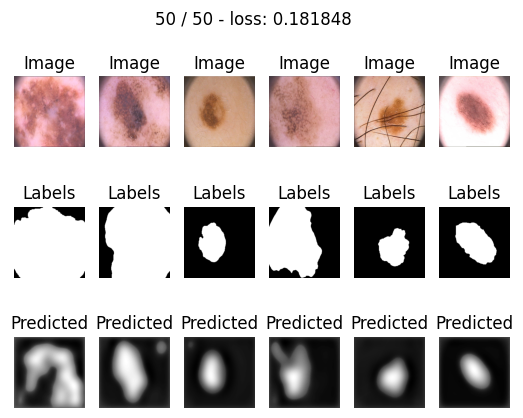

Elapsed time: 416.8
0.9138951778411866


In [ ]:
max_epochs = 50
model = UNet()
loss_function = L.DiceLoss('binary')
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.00001)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)

## 6 варинат DiceLoss 0.0001

Epoch: 1/10, train loss: 0.594405, test loss: 0.632358, train score: 0.672265, test score: 0.652234
Epoch: 2/10, train loss: 0.595655, test loss: 0.566359, train score: 0.667598, test score: 0.666033
Epoch: 3/10, train loss: 0.583369, test loss: 0.589071, train score: 0.326676, test score: 0.377293
Epoch: 4/10, train loss: 0.521279, test loss: 0.452914, train score: 0.327913, test score: 0.294745
Epoch: 5/10, train loss: 0.510652, test loss: 0.548414, train score: 0.341237, test score: 0.339049
Epoch: 6/10, train loss: 0.517404, test loss: 0.486231, train score: 0.328560, test score: 0.351718
Epoch: 7/10, train loss: 0.511120, test loss: 0.513689, train score: 0.334951, test score: 0.371098
Epoch: 8/10, train loss: 0.516501, test loss: 0.482090, train score: 0.335451, test score: 0.344823
Epoch: 9/10, train loss: 0.495997, test loss: 0.528744, train score: 0.330058, test score: 0.344312
Epoch: 10/10, train loss: 0.493361, test loss: 0.552446, train score: 0.330012, test score: 0.287956

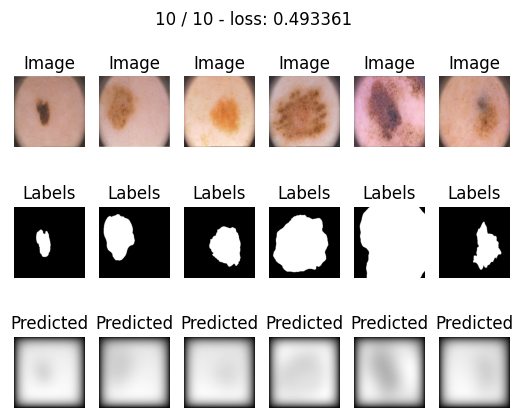

Elapsed time: 83.1
0.3218472868204117


In [ ]:
max_epochs = 10
model = UNet()
loss_function = L.DiceLoss('binary')
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.0001)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)

## 7 варинат SoftBCEWithLogitsLoss 0.00001

Epoch: 1/50, train loss: 0.698574, test loss: 0.696420, train score: 0.672342, test score: 0.703558
Epoch: 2/50, train loss: 0.696541, test loss: 0.695973, train score: 0.674119, test score: 0.642440
Epoch: 3/50, train loss: 0.695235, test loss: 0.694488, train score: 0.658410, test score: 0.665702
Epoch: 4/50, train loss: 0.693538, test loss: 0.693246, train score: 0.666228, test score: 0.661376
Epoch: 5/50, train loss: 0.691362, test loss: 0.690681, train score: 0.653697, test score: 0.693913
Epoch: 6/50, train loss: 0.689161, test loss: 0.688476, train score: 0.651904, test score: 0.697245
Epoch: 7/50, train loss: 0.686767, test loss: 0.688017, train score: 0.668268, test score: 0.686591
Epoch: 8/50, train loss: 0.683328, test loss: 0.681187, train score: 0.655577, test score: 0.674274
Epoch: 9/50, train loss: 0.679487, test loss: 0.676461, train score: 0.671371, test score: 0.645540
Epoch: 10/50, train loss: 0.674851, test loss: 0.675880, train score: 0.652070, test score: 0.701425

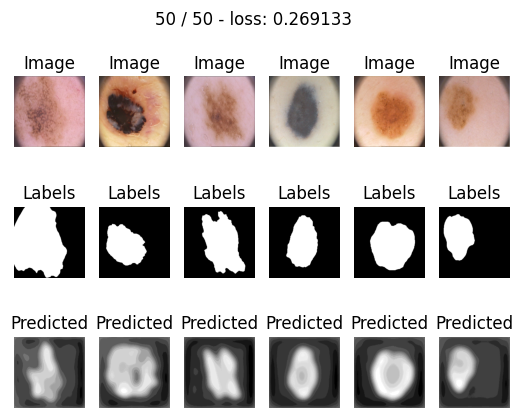

Elapsed time: 417.2
0.9369898676872254


In [ ]:
max_epochs = 50
model = UNet()
loss_function = L.SoftBCEWithLogitsLoss()
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.00001)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)

## 8 варинат SoftBCEWithLogitsLoss 0.0001

Epoch: 1/50, train loss: 0.690930, test loss: 0.683911, train score: 0.663186, test score: 0.687432
Epoch: 2/50, train loss: 0.675290, test loss: 0.658360, train score: 0.648171, test score: 0.615890
Epoch: 3/50, train loss: 0.639224, test loss: 0.578872, train score: 0.654700, test score: 0.685976
Epoch: 4/50, train loss: 0.588800, test loss: 0.585928, train score: 0.668262, test score: 0.643916
Epoch: 5/50, train loss: 0.565870, test loss: 0.567311, train score: 0.669769, test score: 0.615890
Epoch: 6/50, train loss: 0.556011, test loss: 0.553471, train score: 0.682476, test score: 0.689802
Epoch: 7/50, train loss: 0.560901, test loss: 0.587914, train score: 0.669978, test score: 0.664514
Epoch: 8/50, train loss: 0.494996, test loss: 0.553492, train score: 0.672625, test score: 0.684200
Epoch: 9/50, train loss: 0.477944, test loss: 0.449420, train score: 0.662184, test score: 0.668367
Epoch: 10/50, train loss: 0.479728, test loss: 0.449325, train score: 0.670471, test score: 0.704266

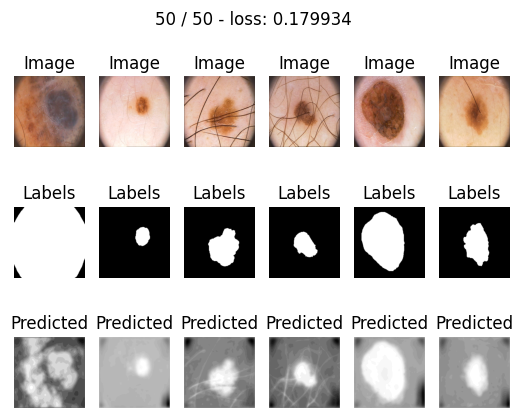

Elapsed time: 414.8
0.9509735345840454


In [ ]:
max_epochs = 50
model = UNet()
loss_function = L.SoftBCEWithLogitsLoss()
model.__init__()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.0001)
train(model, optim, loss_function, max_epochs, data_tr,data_val)
final_score = score_model(model, iou_pytorch, data_ts)
print(final_score)